In [15]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import numpy as np
import seaborn as sns

# Download play data from public Galaxy history

In [ ]:
# Create a folder to store the files
output_folder = "galaxy_data"
os.makedirs(output_folder, exist_ok=True)

# URLs to download
urls = {
    "checkm": 'https://usegalaxy.eu/api/datasets/26c75dcccb616ac86ea31b43000ed2ed/display?to_ext=tabular',
    "checkm2": 'https://usegalaxy.eu/api/datasets/26c75dcccb616ac80f3a06a8ad0904d7/display?to_ext=tabular',
    "gtdb": 'https://usegalaxy.eu/api/datasets/26c75dcccb616ac895e875484621953d/display?to_ext=tsv',
    "drep": 'https://usegalaxy.eu/api/datasets/26c75dcccb616ac88b38f3668ceee538/display?to_ext=csv',
    "coverm_1": 'https://usegalaxy.eu/api/datasets/26c75dcccb616ac87a0137b88d55f3ee/display?to_ext=tabular',
    "coverm_2": 'https://usegalaxy.eu/api/datasets/26c75dcccb616ac85ef07ff9c562fcb9/display?to_ext=tabular',
    "coverm_3": 'https://usegalaxy.eu/api/datasets/26c75dcccb616ac8291512156b45edfa/display?to_ext=tabular'
}

# Download each file
for name, url in urls.items():
    print(f"Downloading {name}...")
    response = requests.get(url)
    response.raise_for_status()  # stop if there's an error
    # Determine extension from URL or default to .txt
    ext = url.split("to_ext=")[-1]
    filepath = os.path.join(output_folder, f"{name}.{ext}")
    with open(filepath, "wb") as f:
        f.write(response.content)
    print(f"Saved to {filepath}")

print("All files downloaded.")

Saved to galaxy_data/checkm.tabular
Saved to galaxy_data/checkm2.tabular
Saved to galaxy_data/gtdb.tsv
Saved to galaxy_data/drep.csv
Saved to galaxy_data/coverm_1.tabular
Saved to galaxy_data/coverm_2.tabular
Saved to galaxy_data/coverm_3.tabular
All files downloaded.


# Load as dfs

In [49]:
# Folder where files were downloaded
folder = "galaxy_data"

# File paths
files = {
    "checkm": os.path.join(folder, "checkm.tabular"),
    "checkm2": os.path.join(folder, "checkm2.tabular"),
    "gtdb": os.path.join(folder, "gtdb.tsv"),
    "drep": os.path.join(folder, "drep.csv"),
    "coverm_1": os.path.join(folder, "coverm_1.tabular"),
    "coverm_2": os.path.join(folder, "coverm_2.tabular"),
    "coverm_3": os.path.join(folder, "coverm_3.tabular")
}

# Load each file into a dataframe
dfs = {}
for name, path in files.items():
    if path.endswith(".csv"):
        dfs[name] = pd.read_csv(path, index_col=0)
    elif path.endswith(".tsv") or path.endswith(".tabular"):
        dfs[name] = pd.read_csv(path, sep="\t", index_col=0)
    else:
        dfs[name] = pd.read_csv(path, index_col=0)  # fallback
    print(f"{name} loaded: {dfs[name].shape} rows x columns")

checkm loaded: (134, 13) rows x columns
checkm2 loaded: (134, 13) rows x columns
gtdb loaded: (134, 19) rows x columns
drep loaded: (155, 5) rows x columns
coverm_1 loaded: (135, 1) rows x columns
coverm_2 loaded: (135, 1) rows x columns
coverm_3 loaded: (135, 1) rows x columns


# Merge coverm

In [55]:
# List of CoverM DataFrames
coverm_dfs = [dfs['coverm_1'], dfs['coverm_2'], dfs['coverm_3']]

clean_dfs = []

for df in coverm_dfs:
    # Set 'Genome' as the index
    # df = df.set_index('Genome')
    clean_dfs.append(df)

# Concatenate horizontally
coverm_merged = pd.concat(clean_dfs, axis=1)

coverm_merged.head()

SRR22878281.fastq Relative Abundance (%)  \
Genome                                                                    
unmapped                                                      57.864082   
SRR22878281.fastq_bin_1030637                                  0.274132   
SRR22878281.fastq_bin_1047037                                  0.199115   
SRR22878281.fastq_bin_1048668                                  0.753555   
SRR22878281.fastq_bin_1065179                                  0.131559   

                               SRR22878282.fastq Relative Abundance (%)  \
Genome                                                                    
unmapped                                                      80.509690   
SRR22878281.fastq_bin_1030637                                  0.000000   
SRR22878281.fastq_bin_1047037                                  0.007188   
SRR22878281.fastq_bin_1048668                                  0.000000   
SRR22878281.fastq_bin_1065179                                  0.000000   

                               SRR22878283.fastq Relative Abundance (%)  
Genome                                                                   
unmapped                                                      63.900536  
SRR22878281.fastq_bin_1030637                                  0.000000  
SRR22878281.fastq_bin_1047037                                  0.009929  
SRR22878281.fastq_bin_1048668                                  0.000000  
SRR22878281.fastq_bin_1065179                                  0.000000

In [ ]:
# Show index for each DataFrame
for name, df in dfs.items():
    print(name, df.index[2])

checkm SRR22878281.fastq_bin_1048668.fasta
checkm2 SRR22878281.fastq_bin_1048668.fasta
gtdb SRR22878281_fastq_bin_1048668_fasta
drep SRR22878281.fastq_bin_1070024.fasta
coverm_1 SRR22878281.fastq_bin_1047037
coverm_2 SRR22878281.fastq_bin_1047037
coverm_3 SRR22878281.fastq_bin_1047037


# Tax sanky

In [6]:
import pandas as pd
import plotly.graph_objects as go

# Use your dataframe
df = df_gtdb

# --- Split taxonomy string into levels ---
tax_split = df["classification"].str.split(";", expand=True)
tax_split.columns = ["domain", "phylum", "class", "order", "family", "genus", "species"]

# Clean up missing/empty values
tax_split = tax_split.replace({"": None, " ": None})

# --- Build source-target pairs for Sankey ---
links = []
for i in range(len(tax_split.columns) - 1):
    pairs = (
        tax_split[[tax_split.columns[i], tax_split.columns[i+1]]]
        .dropna()
        .value_counts()
        .reset_index(name="count")
    )
    pairs.columns = ["source", "target", "count"]
    links.append(pairs)

links_df = pd.concat(links, ignore_index=True)

# --- Build mapping of node names to indices ---
nodes = pd.Index(pd.concat([links_df["source"], links_df["target"]]).unique())
node_map = {name: i for i, name in enumerate(nodes)}

# Map source/target to indices
links_df["source_idx"] = links_df["source"].map(node_map)
links_df["target_idx"] = links_df["target"].map(node_map)

# --- Assign colors based on taxonomy rank ---
rank_colors = {
    "domain": "#1f77b4",   # blue
    "phylum": "#ff7f0e",   # orange
    "class": "#2ca02c",    # green
    "order": "#d62728",    # red
    "family": "#9467bd",   # purple
    "genus": "#8c564b",    # brown
    "species": "#e377c2"   # pink
}

node_colors = []
for node in nodes:
    assigned = False
    for rank in tax_split.columns:
        if node in tax_split[rank].values:
            node_colors.append(rank_colors[rank])
            assigned = True
            break
    if not assigned:
        node_colors.append("lightgray")  # fallback color

# --- Make labels nicer (add line breaks to avoid overlap) ---
clean_labels = [label.replace(";", ";\n") if label else "" for label in nodes]

# --- Create Sankey diagram ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=clean_labels,
        color=node_colors
    ),
    link=dict(
        source=links_df["source_idx"],
        target=links_df["target_idx"],
        value=links_df["count"]
    )
)])

# --- Layout adjustments ---
fig.update_layout(
    title_text="Taxonomic Classification Sankey",
    font=dict(size=10),
    width=1600,   # wider to reduce overlap
    height=900
)

fig.show()


In [12]:
import pandas as pd
import plotly.graph_objects as go

# Copy your dataframe
df = df_gtdb.copy()

# --- Split taxonomy into levels ---
tax_split = df["classification"].str.split(";", expand=True)
tax_split.columns = ["domain", "phylum", "class", "order", "family", "genus", "species"]
tax_split = tax_split.replace({"": None, " ": None})

# --- Choose the taxonomic rank to display ---
# Options: "domain", "phylum", "class", "order", "family", "genus", "species"
selected_rank = "genus"

# Create a simplified dataframe: genome ID → selected rank
df_sankey = df[["user_genome"]].copy()
df_sankey[selected_rank] = tax_split[selected_rank]

# --- Build source-target links ---
links_df = df_sankey.groupby(["user_genome", selected_rank]).size().reset_index(name="count")
links_df.columns = ["source", "target", "count"]

# --- Build node mapping ---
nodes = pd.Index(pd.concat([links_df["source"], links_df["target"]]).unique())
node_map = {name: i for i, name in enumerate(nodes)}
links_df["source_idx"] = links_df["source"].map(node_map)
links_df["target_idx"] = links_df["target"].map(node_map)

# --- Assign colors ---
rank_colors = {
    "genome": "#7f7f7f",   # gray
    "domain": "#1f77b4",
    "phylum": "#ff7f0e",
    "class": "#2ca02c",
    "order": "#d62728",
    "family": "#9467bd",
    "genus": "#8c564b",
    "species": "#e377c2"
}

node_colors = []
for node in nodes:
    if node in df_sankey["user_genome"].values:
        node_colors.append(rank_colors["genome"])
    else:
        node_colors.append(rank_colors.get(selected_rank, "lightgray"))

# --- Clean labels for readability ---
clean_labels = [str(label).replace(";", ";\n") if label else "" for label in nodes]

# --- Create Sankey diagram ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=clean_labels,
        color=node_colors
    ),
    link=dict(
        source=links_df["source_idx"],
        target=links_df["target_idx"],
        value=links_df["count"]
    )
)])

# --- Layout ---
fig.update_layout(
    title_text=f"Genome → {selected_rank.capitalize()} Sankey",
    font=dict(size=10),
    width=1200,
    height=800
)

fig.show()


   Completeness (%)  Contamination (%)
0             98.29               1.99
1             88.35               1.69
2             96.95               1.22
3             92.38               3.20
4             92.59               1.28


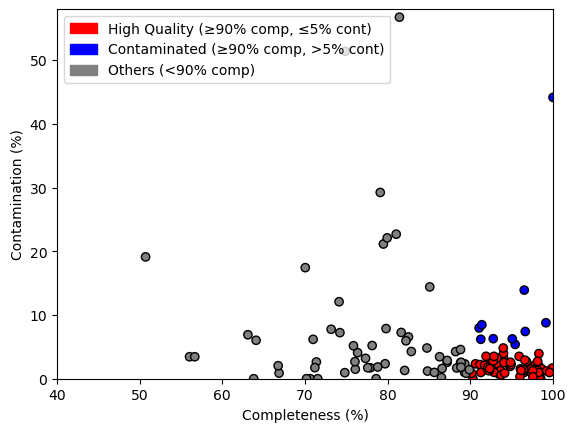

In [8]:
#CONTAMINATION x COMPLETNESS

plot_df = df_checkm.loc[:,['Completeness', 'Contamination']]

plot_df.rename(columns={'Completeness': 'Completeness (%)', 'Contamination': 'Contamination (%)'}, inplace=True)

print(plot_df.head())


completness = 90.0
contamination = 5.0

conditions = [(plot_df['Completeness (%)'] >= completness) & (plot_df['Contamination (%)'] <= contamination), (plot_df['Completeness (%)'] >= completness) & (plot_df['Contamination (%)'] > contamination)]

choices = ['red', 'blue']

colors = np.select(conditions, choices, default='grey')

plt.scatter(x=plot_df['Completeness (%)'], y=plot_df['Contamination (%)'], c=colors, edgecolor='black')

plt.xlim(max(math.floor((plot_df['Completeness (%)'].min() - 10) / 10) * 10 ,0), 100)
plt.ylim(0, min(math.ceil(plot_df['Contamination (%)'].max() + 1), 100))

plt.xlabel('Completeness (%)')
plt.ylabel('Contamination (%)')

legend_patches = [
    mpatches.Patch(color='red', label='High Quality (≥90% comp, ≤5% cont)'),
    mpatches.Patch(color='blue', label='Contaminated (≥90% comp, >5% cont)'),
    mpatches.Patch(color='grey', label='Others (<90% comp)')
]
plt.legend(handles=legend_patches, loc='best')

plt.show()

   N50(kbp)
0    52.200
1    16.112
2    62.436
3     9.080
4    34.002


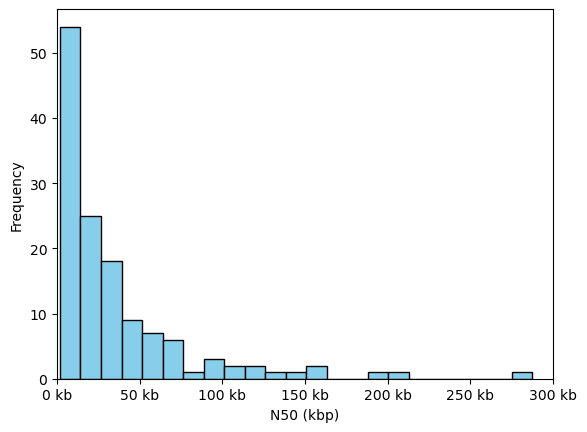

In [19]:
#N50 HISTOGRAM

his_df = df_checkm2.loc[:,['Contig_N50']]

his_df.rename(columns={'Contig_N50': 'N50(kbp)'}, inplace=True)

his_df = his_df / 1000

print(his_df.head())

plt.hist(his_df, bins='auto', color='skyblue', edgecolor='black')

plt.xlim(0, his_df['N50(kbp)'].max())

plt.xlabel('N50 (kbp)')
plt.ylabel('Frequency')

plt.xticks(plt.xticks()[0], [f'{int(x)} kb' for x in plt.xticks()[0]])

plt.show()

   # Contig
0       152
1       328
2        78
3       865
4       176


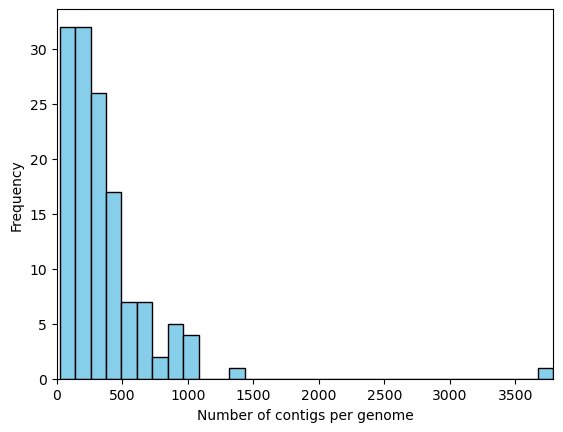

In [20]:
#NUMBER OF CONTIGS HISTOGRAM

his_df = df_checkm2.loc[:,['Total_Contigs']]

his_df.rename(columns={'Total_Contigs': '# Contig'}, inplace=True)

print(his_df.head())

plt.hist(his_df, bins='auto', color='skyblue', edgecolor='black')

plt.xlim(0, his_df['# Contig'].max())

plt.xlabel('Number of contigs per genome')
plt.ylabel('Frequency')

plt.show()

                                   Bin    N50  Total length Assembly  \
0  SRR22878281.fastq_bin_1030637.fasta  52200                4867065   
1  SRR22878281.fastq_bin_1047037.fasta  16112                3654981   
2  SRR22878281.fastq_bin_1048668.fasta  62436                2677092   
3  SRR22878281.fastq_bin_1065179.fasta   9080                5913631   
4  SRR22878281.fastq_bin_1069559.fasta  34002                3943993   

   Longest Contig  Coding Density  
0          183065           0.930  
1           96306           0.887  
2          190839           0.887  
3           38672           0.926  
4           77593           0.935  


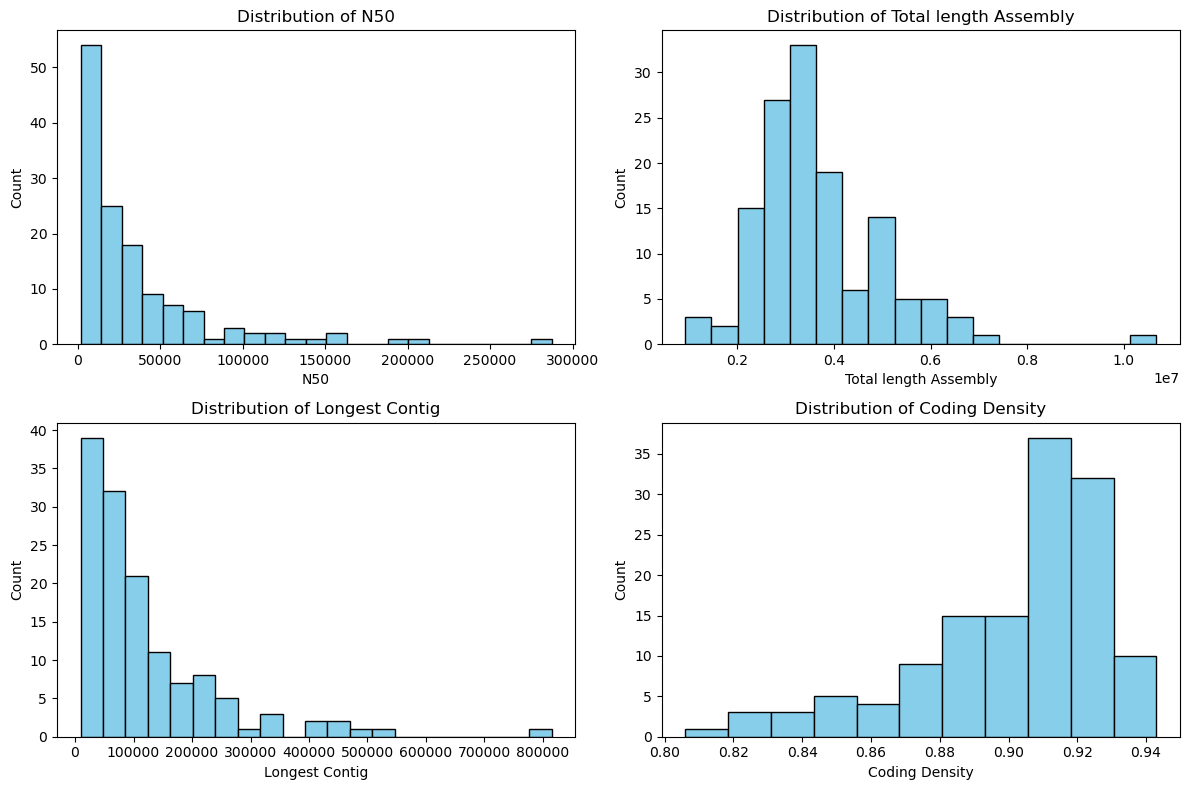

In [21]:
#N50 VALUES x TOTAL LENGTH OF THE ASSEMLBY x LENGTH OF THE LONGEST CONTIG x CODDING DENSITY

plot_df = df_checkm2.loc[:,['Name', 'Contig_N50', 'Genome_Size', 'Max_Contig_Length', 'Coding_Density']]

plot_df.rename(columns={'Name': 'Bin', 'Genome_Size': 'Total length Assembly', 'Contig_N50' : 'N50', 'Max_Contig_Length': 'Longest Contig', 'Coding_Density': 'Coding Density'}, inplace=True)

print(plot_df.head())


metrics = ['N50','Total length Assembly','Longest Contig','Coding Density']

fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].hist(plot_df[metric], bins='auto', color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {metric}')
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

#NORMALIZED VALUES

#df_norm = plot_df.copy()
#df_norm[metrics] = plot_df[metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

#fig, axes = plt.subplots(2, 2, figsize=(12,8))
#axes = axes.flatten()

#for i, metric in enumerate(metrics):
    #axes[i].hist(df_norm[metric], bins=20, color='skyblue', edgecolor='black')
    #axes[i].set_title(f'Distribution of {metric} normalized')
    #axes[i].set_xlabel(metric)
    #axes[i].set_ylabel('Count')


#plt.tight_layout()
#plt.show()

                                   Bin             Phylum
0  SRR22878281_fastq_bin_1030637_fasta     Actinomycetota
1  SRR22878281_fastq_bin_1047037_fasta     Pseudomonadota
2  SRR22878281_fastq_bin_1048668_fasta     Pseudomonadota
3  SRR22878281_fastq_bin_1065179_fasta  Verrucomicrobiota
4  SRR22878281_fastq_bin_1069559_fasta     Actinomycetota


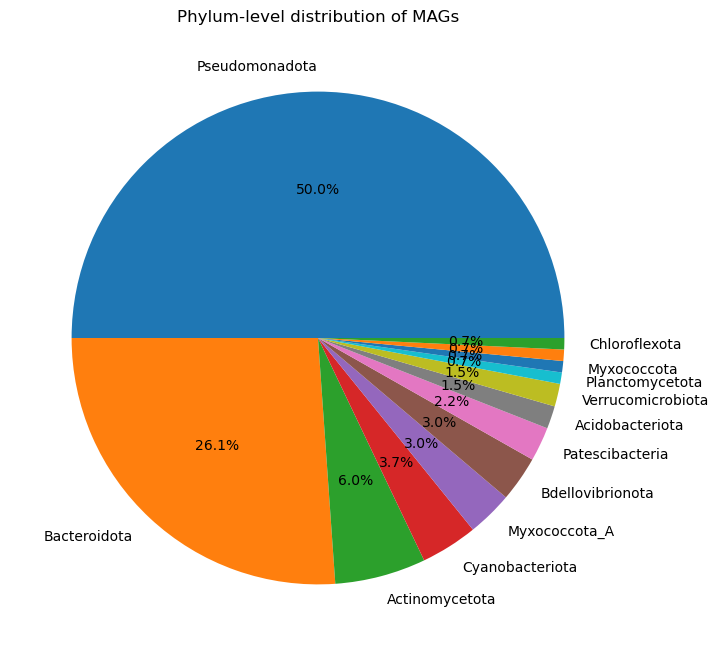

In [22]:
# Phylum-level distribution of MAGs

plot_df = df_gtdb.loc[:,['user_genome', 'classification']]

plot_df.rename(columns={'user_genome': 'Bin', 'classification': 'Phylum'}, inplace=True)

plot_df['Phylum'] = (
    plot_df['Phylum']
    .str.split(';')
    .str[1]
    .str.replace('p__', '', regex=False)
)

plot_df['Phylum'] = plot_df['Phylum'].fillna('Unclassified')

print(plot_df.head())

phylum_counts = plot_df["Phylum"].value_counts()

plt.figure(figsize=(8,8))
phylum_counts.plot(kind="pie", autopct='%1.1f%%')
plt.ylabel("")
plt.title("Phylum-level distribution of MAGs")
plt.show()

#subtrees = [f"gtdb_tree{i}.nwk" for i in range(len(need_to_download))]

#for tfile in subtrees:
    #t = Tree(tfile, format=1, quoted_node_names=True)
    #if full_tree is None:
        #full_tree = t
    #else:
        #full_tree.add_child(t)

#full_tree.write(format=1, outfile="merged_tree.nwk")


#full_tree = Tree("merged_tree.nwk", format=1, quoted_node_names=True)

#ts = TreeStyle()
#ts.mode = "c"
#ts.show_leaf_name = True
#ts.show_branch_length = False
#ts.show_branch_support = True

#full_tree.render("full_tree.png", tree_style=ts)

                                   Bin Cluster
0  SRR22878281.fastq_bin_1069559.fasta     1_0
1  SRR22878281.fastq_bin_1177133.fasta     2_0
2  SRR22878281.fastq_bin_1070024.fasta     3_0
3   SRR22878281.fastq_bin_952057.fasta     4_0
4     SRR22878281.fastq_bin_6555.fasta     5_0


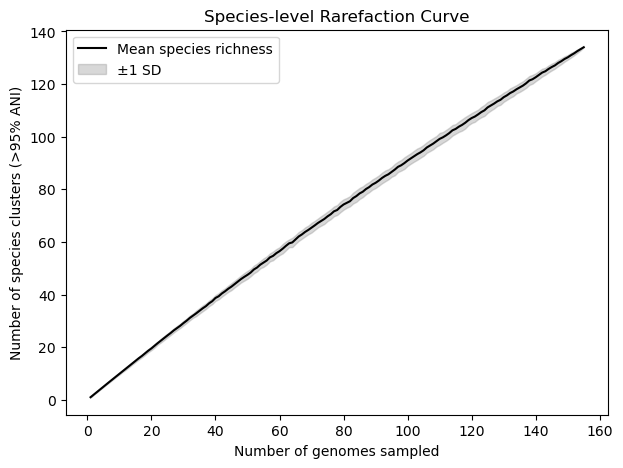

In [23]:
#Species-level (>95% ANI) rarefaction curve

plot_df = df_drep.loc[:,['genome', 'secondary_cluster']]

plot_df.rename(columns={'genome': 'Bin', 'secondary_cluster': 'Cluster'}, inplace=True)

print(plot_df.head())

def rarefaction_curve(df, n_iter=100, step=1):
    genomes = df["Bin"].tolist()
    species_map = dict(zip(df["Bin"], df["Cluster"]))
    
    max_depth = len(genomes)
    depths = range(step, max_depth+1, step)
    results = []
    
    for depth in depths:
        species_counts = []
        for _ in range(n_iter):
            subsample = np.random.choice(genomes, size=depth, replace=False)
            clusters = set(species_map[g] for g in subsample)
            species_counts.append(len(clusters))
        results.append({
            "depth": depth,
            "mean_species": np.mean(species_counts),
            "std_species": np.std(species_counts)
        })
    
    return pd.DataFrame(results)


results = rarefaction_curve(plot_df, n_iter=200, step=1)


plt.figure(figsize=(7,5))
plt.plot(results["depth"], results["mean_species"], label="Mean species richness", color="black")
plt.fill_between(results["depth"],
                 results["mean_species"]-results["std_species"],
                 results["mean_species"]+results["std_species"],
                 color="gray", alpha=0.3, label="±1 SD")
plt.xlabel("Number of genomes sampled")
plt.ylabel("Number of species clusters (>95% ANI)")
plt.title("Species-level Rarefaction Curve")
plt.legend()
plt.show()

                               SRR22878281  SRR22878282  SRR22878283
Genome                                                              
SRR22878281.fastq_bin_1030637     0.274132     0.000000     0.000000
SRR22878281.fastq_bin_1047037     0.199115     0.007188     0.009929
SRR22878281.fastq_bin_1048668     0.753555     0.000000     0.000000
SRR22878281.fastq_bin_1065179     0.131559     0.000000     0.000000
SRR22878281.fastq_bin_1069559     0.208079     0.000000     0.000000


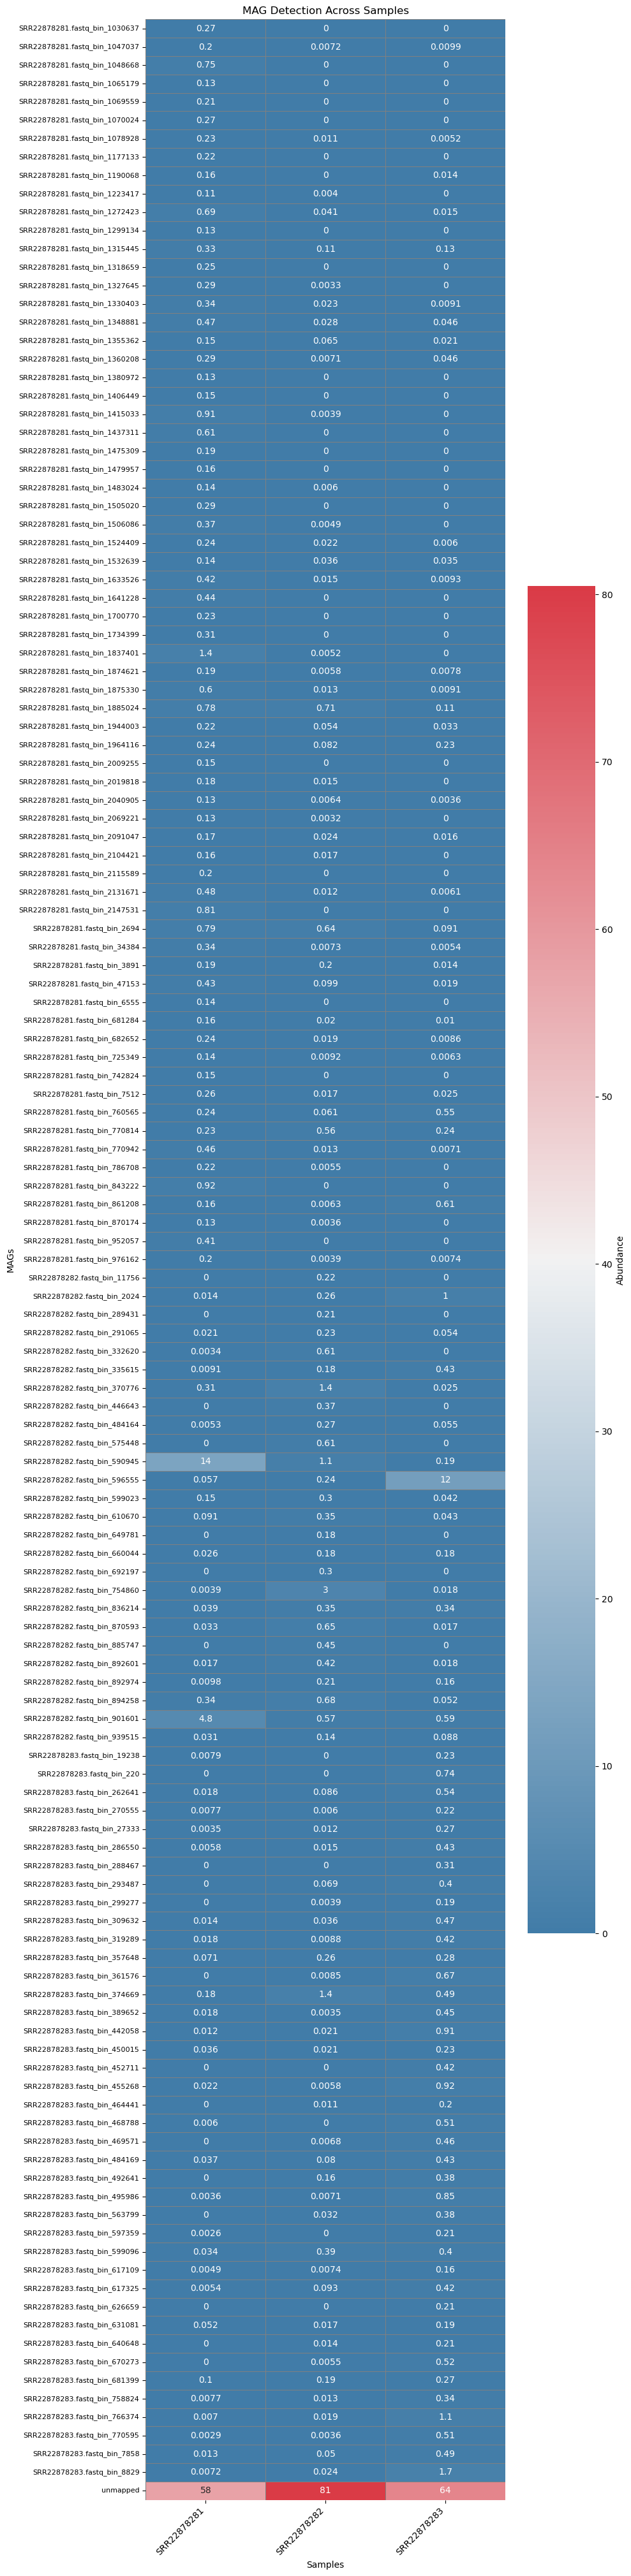

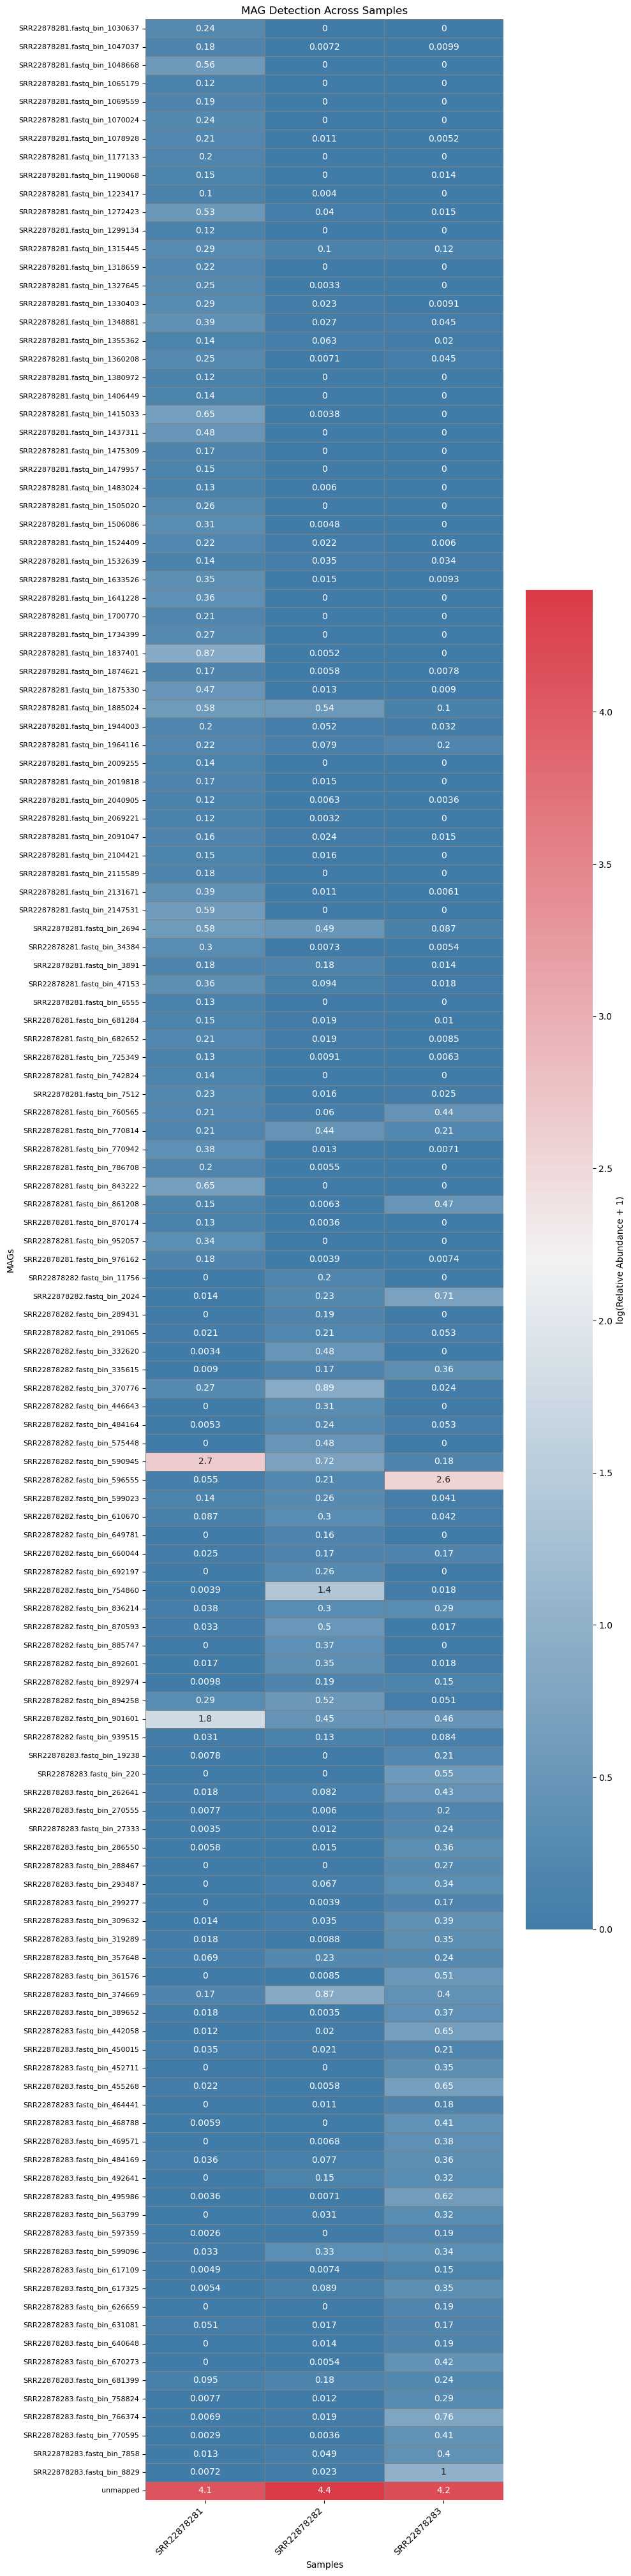

In [42]:
#HEAT MAP

df_sample_1 = pd.read_csv(coverm_sample_1, sep='\t')
df_sample_2 = pd.read_csv(coverm_sample_2, sep='\t')
df_sample_3 = pd.read_csv(coverm_sample_3, sep='\t')

merged = df_sample_1.merge(df_sample_2, on='Genome', how='outer').merge(df_sample_3, on='Genome', how='outer')

merged.columns = merged.columns.str.split(".").str[0]

merged = merged.set_index("Genome")
merged = merged.apply(pd.to_numeric, errors="coerce")
merged = merged.fillna(0)

print(merged.head())

num_bins, num_samples = merged.shape

plt.figure(figsize=(max(10, num_samples*1.2), max(6, num_bins*0.3)))

sns.heatmap(merged, cmap= sns.diverging_palette(240, 10, as_cmap=True), annot=True, cbar_kws={'label': 'Abundance'}, linewidths=0.5,linecolor='gray')

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=8)
plt.title("MAG Detection Across Samples")
plt.xlabel("Samples")
plt.ylabel("MAGs")
plt.tight_layout()
plt.show()

plt.figure(figsize=(max(10, num_samples*1.2), max(6, num_bins*0.3)))

sns.heatmap(np.log1p(merged), cmap= sns.diverging_palette(240, 10, as_cmap=True), annot=True, cbar_kws={'label': 'log(Relative Abundance + 1)'}, linewidths=0.5,linecolor='gray')

plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=8)
plt.title("MAG Detection Across Samples")
plt.xlabel("Samples")
plt.ylabel("MAGs")
plt.tight_layout()
plt.show()